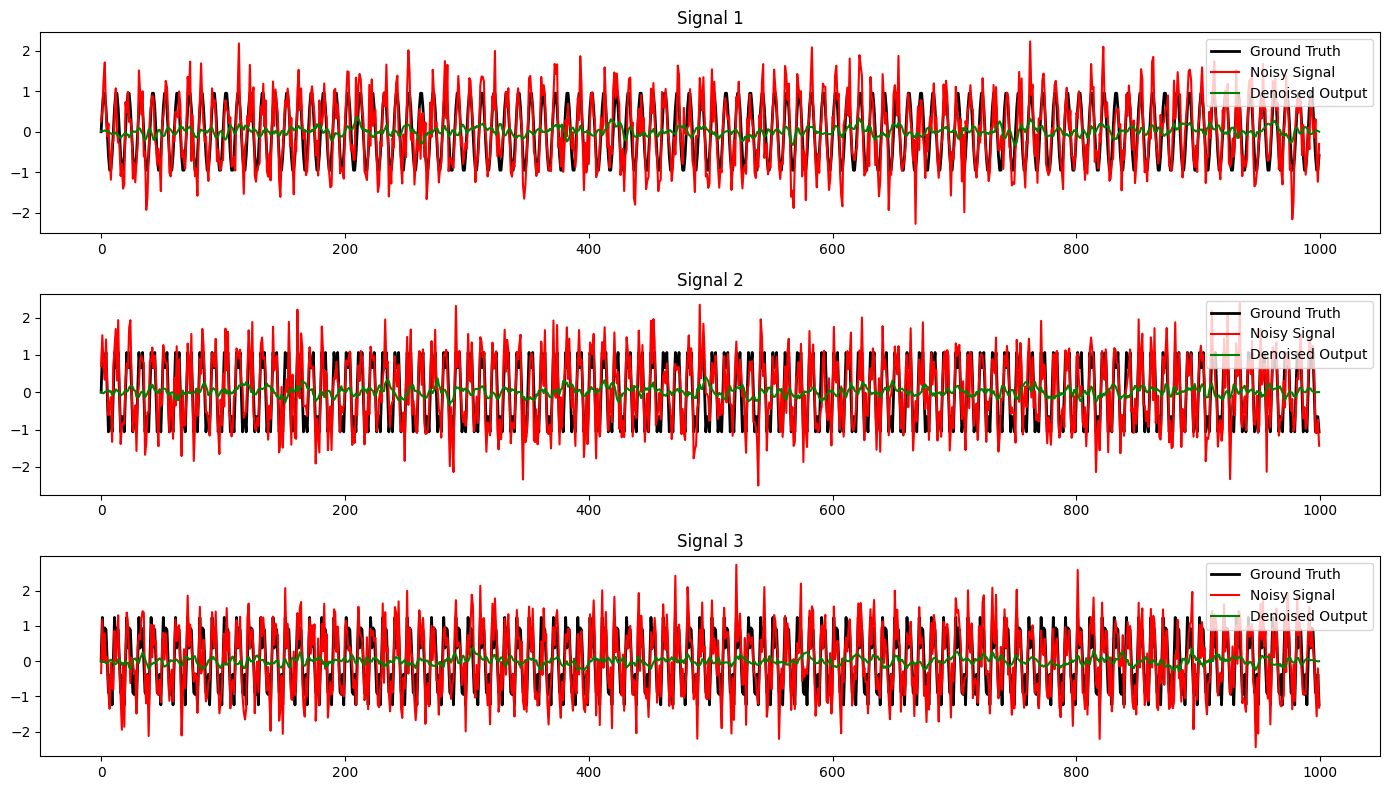

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

# -----------------------
# Signal Generator
# -----------------------
def generate_signals(n_samples=1000, noise_std=0.5):
    t = np.arange(n_samples)

    # Clean oscillatory signals
    s1 = np.sin(2 * np.pi * 0.1 * t)
    s2 = s1 + 0.5 * np.sin(2 * np.pi * 0.3 * t)
    s3 = s2 + 0.3 * np.sin(2 * np.pi * 0.4 * t)
    clean_signals = np.vstack([s1, s2, s3])

    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, clean_signals.shape)
    noised_signals = clean_signals + noise

    return clean_signals, noised_signals

# -----------------------
# MSSA Helper Functions
# -----------------------
def embed_time_series(X, M):
    L, N = X.shape
    K = N - M + 1
    trajectory = np.zeros((L * M, K))
    for l in range(L):
        for i in range(M):
            trajectory[l * M + i] = X[l, i:i + K]
    return trajectory

def compute_dfa(signal, min_scale=4, max_scale=50):
    N = len(signal)
    scales = np.floor(np.logspace(np.log10(min_scale), np.log10(max_scale), num=20)).astype(int)
    fluctuations = []
    profile = np.cumsum(signal - np.mean(signal))

    for scale in scales:
        segments = N // scale
        rms = []
        for i in range(segments):
            idx = slice(i * scale, (i + 1) * scale)
            segment = profile[idx]
            x = np.arange(scale)
            coeffs = np.polyfit(x, segment, deg=1)
            trend = np.polyval(coeffs, x)
            rms.append(np.sqrt(np.mean((segment - trend) ** 2)))
        fluctuations.append(np.mean(rms))

    log_scales = np.log(scales)
    log_flucts = np.log(fluctuations)
    slope, _ = np.polyfit(log_scales, log_flucts, 1)
    return slope

# -----------------------
# MSSA-DFA Denoising Core
# -----------------------
def mssa_dfa_denoise(X, M=30, dfa_threshold=1.0):
    L, N = X.shape
    trajectory = embed_time_series(X, M)
    U, Sigma, VT = svd(trajectory, full_matrices=False)

    RCs = []
    for k in range(U.shape[1]):
        Uk = U[:, k].reshape((L, M))
        Sk = Sigma[k]
        Vk = VT[k, :]
        RC_k = np.zeros((L, N))
        for l in range(L):
            for i in range(N - M + 1):
                RC_k[l, i:i + M] += Sk * Uk[l, :] * Vk[i]
        RC_k /= M
        RCs.append(RC_k)

    # DFA filtering
    selected = []
    for k, RC_k in enumerate(RCs):
        keep = False
        for l in range(L):
            alpha = compute_dfa(RC_k[l])
            if alpha > dfa_threshold:
                keep = True
        if keep:
            selected.append(RC_k)

    if not selected:
        print("⚠️ No components passed DFA threshold. Try lowering the threshold.")
        return np.zeros_like(X)

    denoised = np.sum(selected, axis=0)
    return denoised

# -----------------------
# Plotting Function
# -----------------------
def plot_results(clean, noisy, denoised):
    fig, axs = plt.subplots(3, 1, figsize=(14, 8))
    t = np.arange(clean.shape[1])
    for i in range(3):
        axs[i].plot(t, clean[i], label="Ground Truth", color='black', linewidth=2)
        axs[i].plot(t, noisy[i], label="Noisy Signal", color='red', alpha=1.0)
        axs[i].plot(t, denoised[i], label="Denoised Output", color='green')
        axs[i].set_title(f"Signal {i+1}")
        axs[i].legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# -----------------------
# Main Execution
# -----------------------
if __name__ == "__main__":
    np.random.seed(42)
    clean_signals, noisy_signals = generate_signals(n_samples=1000, noise_std=0.5)
    denoised_signals = mssa_dfa_denoise(noisy_signals, M=30, dfa_threshold=1.0)
    plot_results(clean_signals, noisy_signals, denoised_signals)


In [ ]:
from sklearn.metrics import mean_squared_error

# -----------------------
# RMSE Utility
# -----------------------
def compute_rmse(true_signal, denoised_signal):
    return np.sqrt(np.mean((true_signal - denoised_signal)**2, axis=1))  # per signal

# -----------------------
# Threshold Optimizer
# -----------------------
def find_best_dfa_threshold(clean_signals, noisy_signals, thresholds=np.linspace(0.5, 1.5, 11), M=30, verbose=True):
    best_rmse = np.inf
    best_threshold = None
    rmse_scores = []

    for threshold in thresholds:
        denoised = mssa_dfa_denoise(noisy_signals, M=M, dfa_threshold=threshold)
        rmse_per_signal = compute_rmse(clean_signals, denoised)
        avg_rmse = np.mean(rmse_per_signal)
        rmse_scores.append(avg_rmse)

        if verbose:
            print(f"DFA threshold: {threshold:.2f} → Avg RMSE: {avg_rmse:.4f}")

        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_threshold = threshold

    if verbose:
        print(f"\n Best threshold: {best_threshold:.2f} with Avg RMSE: {best_rmse:.4f}")

    # Optional: plot
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 4))
        plt.plot(thresholds, rmse_scores, marker='o')
        plt.xlabel("DFA Threshold")
        plt.ylabel("Avg RMSE")
        plt.title("DFA Threshold vs Denoising RMSE")
        plt.grid(True)
        plt.show()
    except:
        pass

    return best_threshold, rmse_scores


DFA threshold: 0.10 → Avg RMSE: 0.5426
DFA threshold: 0.17 → Avg RMSE: 0.4971
DFA threshold: 0.25 → Avg RMSE: 0.4644
DFA threshold: 0.32 → Avg RMSE: 0.4428
DFA threshold: 0.39 → Avg RMSE: 0.4230
DFA threshold: 0.47 → Avg RMSE: 0.4066
DFA threshold: 0.54 → Avg RMSE: 0.3945
DFA threshold: 0.62 → Avg RMSE: 0.3744
DFA threshold: 0.69 → Avg RMSE: 0.3654
DFA threshold: 0.76 → Avg RMSE: 0.3596
DFA threshold: 0.84 → Avg RMSE: 0.7885
DFA threshold: 0.91 → Avg RMSE: 0.7814
DFA threshold: 0.98 → Avg RMSE: 0.7801
DFA threshold: 1.06 → Avg RMSE: 0.7760
DFA threshold: 1.13 → Avg RMSE: 0.7750
DFA threshold: 1.21 → Avg RMSE: 0.7743
DFA threshold: 1.28 → Avg RMSE: 0.7743
DFA threshold: 1.35 → Avg RMSE: 0.7734
DFA threshold: 1.43 → Avg RMSE: 0.7734
DFA threshold: 1.50 → Avg RMSE: 0.7725

✅ Best threshold: 0.76 with Avg RMSE: 0.3596


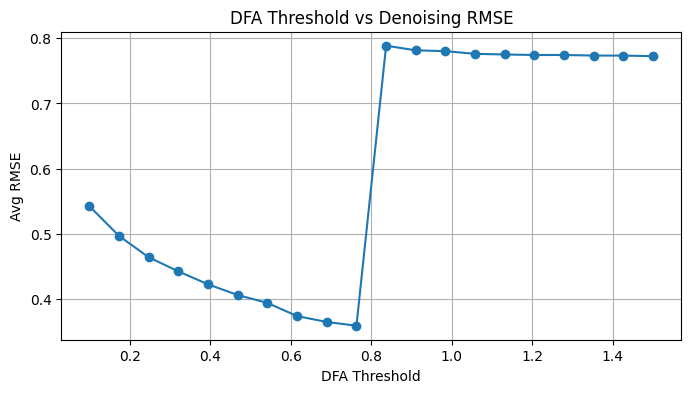

/tmp/ipykernel_94235/2685787546.py:108: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_94235/2685787546.py:108: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_94235/2685787546.py:108: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


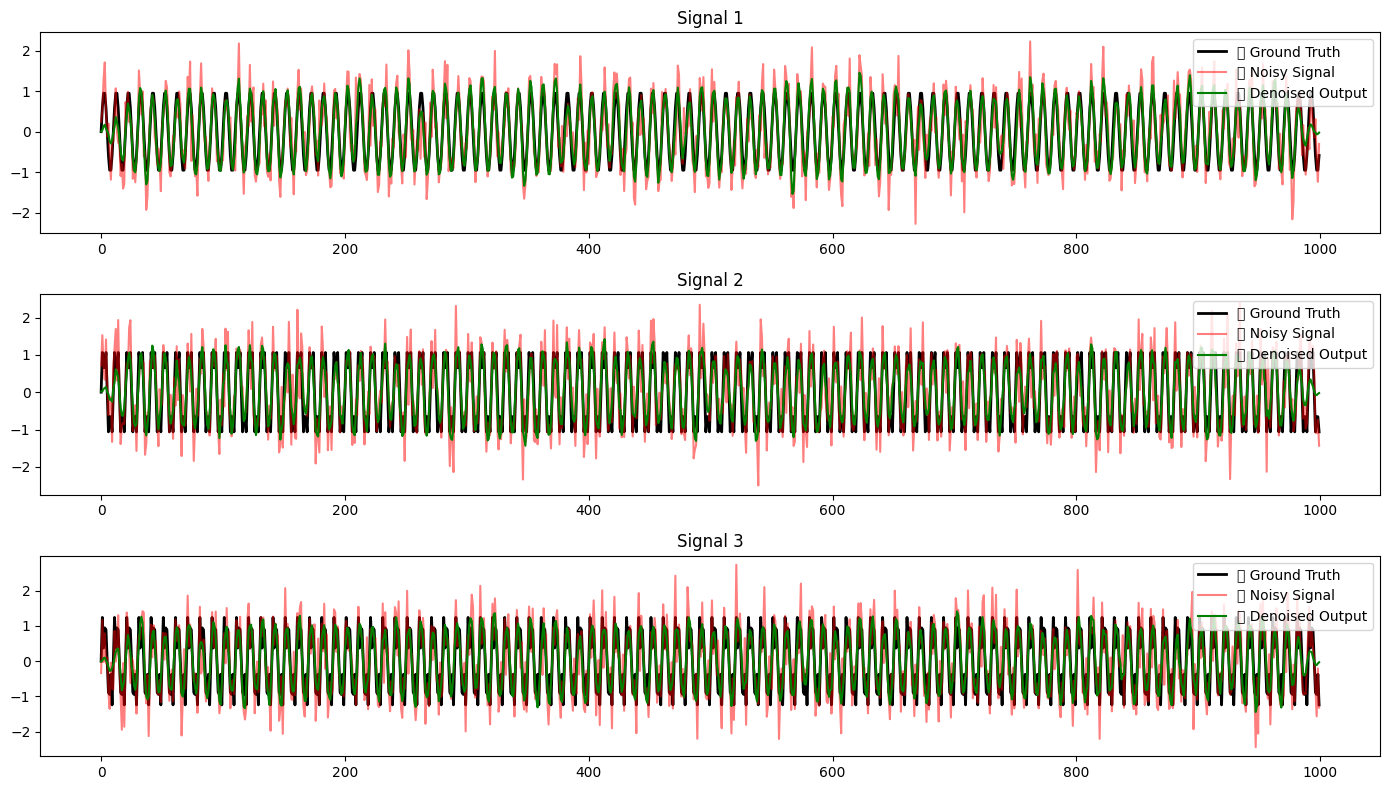

In [14]:
    # Find best DFA threshold
    best_thresh, _ = find_best_dfa_threshold(clean_signals, noisy_signals, thresholds=np.linspace(0.1, 1.5, 20), M=30)

    # Use best threshold for final denoising
    final_denoised = mssa_dfa_denoise(noisy_signals, M=30, dfa_threshold=best_thresh)

    # Plot comparison
    plot_results(clean_signals, noisy_signals, final_denoised)
